<a href="https://colab.research.google.com/github/armindocachada/tensorflow-custom-classification-art-nativity/blob/main/custom_image_classification_detect_if_a_painting_is_from_the_nativity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Object Detection API - Custom Image Classification - Can I detect if a painting is a nativity painting?

Can I teach an AI model using Tensorflow Object Detection API, how to identify the theme of a painting?

The only way to find out is by trying! And I think you might be surprised by the outcome of this experiment.

But, I am going to narrow down my problem. I want to identify if a painting is about the **Nativity** or not.
Which is simple binary classification problem.

But first let me explain what a nativity painting is. A nativity painting is a painting where the subject is the birth of Jesus Christ, very revered in Christianity. 
During the last two thousand years, many famous artists like, for example, Leonardo Da Vinci, were commissioned to create paintings for Churches, so there should be plenty of paintings to pick about the nativity.


![The Nativity By Boticelli](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Botticelli%2C_adorazione_dei_magi_uffizi.jpg/600px-Botticelli%2C_adorazione_dei_magi_uffizi.jpg "The Nativity By Boticelli")

When trying to identify a painting about the **nativity** you will almost always see **Baby Jesus** in the center. And, almost always, you will see his **Mother Mary** and his **Father Joseph**. You will see sometimes **animals** around **Baby Jesus**, because he was born in a stable. Sometimes you will see him in a cave.
And sometimes he is outside and surrounded by shepherds, and so on. 

I hope you can agree with me. There is NO WAY that we can write any code that can take account of all these different variations. 

Remember what I just said? **Almost always** you will have Baby Jesus in the painting. But surely, a **nativity** painting without **Baby Jesus** makes no sense?
Right. Apparently **Leonardo Da Vinci**, didn't get that message and created a **nativity** painting without its central character. Mind that the **Virgin of the Rocks** is a very famous painting, but for me this is a clear **outlier**.  


![Virgin of the Rocks](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Leonardo_da_Vinci_-_Virgin_of_the_Rocks_%28National_Gallery_London%29.png/311px-Leonardo_da_Vinci_-_Virgin_of_the_Rocks_%28National_Gallery_London%29.png)

Therefore for the sake of not confusing our **Deep Neural Network**, I am not going to include the **Virgin on the Rocks** in the training or validation while building our model. But just for fun at the end we will see if our model really can be smarter than what we think.

Ok. Now that you know what I am trying to build, for the sake of learning Tensorflow. You will quite rightly think. There is no way this will ever work?!

Before you rush into judgement, hold on to your paper! Let's find out!


# Before Starting

I created this notebook with code from the "Tensorflow tutorial on **Image Classification**. You can find the original tutorial in the link below: 

https://www.tensorflow.org/tutorials/images/classification








# Import TensorFlow and other libraries

In [17]:
import matplotlib.pyplot as plt 
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import requests # to get image from the web
import shutil # to save it locally
import time
import numpy as np

# Download Training, Validation and Test Image Data Sets

In order to train an image classifier we need to have a **training** image dataset, **validation** dataset and a **test** dataset.

Since we are training a binary image classifier, we will have images for two different classes:


*   Nativity
*   Others

During the training of our model we will use the training dataset to teach the model how to classify a painting: either a **nativity** painting or not(**other**).

At the end of each training cycle(epoch) we will use the validationg data-set to score how well the model is doing by calculating the **accuracy** and the **loss**. The **accuracy** measures how many times our model got the right answer. **Higher** is better. The **loss** measures the delta, i.e. the difference between the predicted value and the actual value. **Lower** is better.

It is important that the **validation** data set is **separate** from the **training** dataset because the AI model is very good at cheating. If you don't separate the two, the model, will simply memorise the answers instead of learning the intrinsic characteristics of what we are trying to teach it.

At the end of the training we will also use a separate **test** dataset from the **training** and **validation** dataset, to do an independent benchmark of the model performance. 

You will notice that we are downloading three files:
- nativity_dataset.csv - contains all nativity paintings
- other_dataset.csv - contains many paintings except nativity paintings
- test_dataset.csv - contains labeled paintings

Wait a moment! Did I not just say that the training data set should be separate from the validation data set, so why keep it in the same files?

Yes, but because we are doing data exploration, it is a good thing to have some flexibility. Typically you are advised to have 80% of the training data and 20% of the validation data. But, this is not a hard and fast rule. We might want to change these percentages and see what gives us better results as part of our experimentation. This is also known as **Hyperparameter tuning**. On the other hand the test data set should be fixed, so we can compare different models with different architectures in a consistent way.


Some more utility functions just to help download the images from our image dataset. Notice that **getFileNameFromUrl()** does some very basic **cleanup** and **extraction** of the **filename** in the url.

In [18]:
def getFileNameFromUrl(url):
  firstpos=url.rindex("/")
  lastpos=len(url)
  filename=url[firstpos+1:lastpos]
  print(f"url={url} firstpos={firstpos} lastpos={lastpos} filename={filename}")
  return filename


def downloadImage(imageUrl, destinationFolder):
  filename = getFileNameFromUrl(imageUrl)
  # Open the url image, set stream to True, this will return the stream content.
  r = requests.get(imageUrl, stream = True)

  # Check if the image was retrieved successfully
  if r.status_code == 200:
      # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
      r.raw.decode_content = True
      
      # Open a local file with wb ( write binary ) permission.
      filePath = os.path.join(destinationFolder, filename)
      if not os.path.exists(filePath):
        with open(filePath,'wb') as f:
            shutil.copyfileobj(r.raw, f)
        print('Image sucessfully Downloaded: ',filename)
        print("Sleeping for 1 seconds before attempting next download")
        time.sleep(1)
      else:
        print(f'Skipping image {filename} as it is already Downloaded: ')

  else:
      print(f'Image url={imageUrl} and filename={filename} Couldn\'t be retreived. HTTP Status={r.status_code}')




In [4]:
df = pd.read_csv("nativity_dataset.csv")

# create directory to which we download if it doesn't exist
destinationFolder = "/content/dataset/nativity"
os.makedirs(destinationFolder, exist_ok=True)

for i, row in df.iterrows():
  print(f"Index: {i}")
  print(f"{row['Image URL']}\n")

  downloadImage(row["Image URL"], destinationFolder)
  

Index: 0
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/LSE/CUMU/LSE_CUMU_TN07034-001.jpg

url=https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/LSE/CUMU/LSE_CUMU_TN07034-001.jpg firstpos=68 lastpos=93 filename=LSE_CUMU_TN07034-001.jpg
Image sucessfully Downloaded:  LSE_CUMU_TN07034-001.jpg
Sleeping for 1 seconds before attempting next download
Index: 1
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/GMIII/MCAG/GMIII_MCAG_1947_188-001.jpg

url=https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/GMIII/MCAG/GMIII_MCAG_1947_188-001.jpg firstpos=70 lastpos=98 filename=GMIII_MCAG_1947_188-001.jpg
Image sucessfully Downloaded:  GMIII_MCAG_1947_188-001.jpg
Sleeping for 1 seconds before attempting next download
Index: 2
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/HMPS/SCAG/HMPS_SCAG_1408-001.jpg

url=https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/HMPS/SCAG/HMPS_SCAG_1408-001.jpg firstpos=69 lastpos=92 filename=HMPS_SCAG_14

In [5]:
df = pd.read_csv("other_dataset.csv")

# create directory to which we download if it doesn't exist
destinationFolder = "/content/dataset/others"
os.makedirs(destinationFolder, exist_ok=True)

for i, row in df.iterrows():
  print(f"Index: {i}")
  print(f"{row['Image URL']}\n")

  downloadImage(row["Image URL"], destinationFolder)
  

Index: 0
https://d3d00swyhr67nd.cloudfront.net/w800h800/collection/ASH/ASHM/ASH_ASHM_WA1933_22-001.jpg

url=https://d3d00swyhr67nd.cloudfront.net/w800h800/collection/ASH/ASHM/ASH_ASHM_WA1933_22-001.jpg firstpos=66 lastpos=93 filename=ASH_ASHM_WA1933_22-001.jpg
Image sucessfully Downloaded:  ASH_ASHM_WA1933_22-001.jpg
Sleeping for 1 seconds before attempting next download
Index: 1
https://d3d00swyhr67nd.cloudfront.net/w800h800/collection/ASH/ASHM/ASH_ASHM_WA1940_2_34-001.jpg

url=https://d3d00swyhr67nd.cloudfront.net/w800h800/collection/ASH/ASHM/ASH_ASHM_WA1940_2_34-001.jpg firstpos=66 lastpos=95 filename=ASH_ASHM_WA1940_2_34-001.jpg
Image sucessfully Downloaded:  ASH_ASHM_WA1940_2_34-001.jpg
Sleeping for 1 seconds before attempting next download
Index: 2
https://upload.wikimedia.org/wikipedia/commons/8/8c/Albrecht_D%C3%BCrer_039.jpg

url=https://upload.wikimedia.org/wikipedia/commons/8/8c/Albrecht_D%C3%BCrer_039.jpg firstpos=51 lastpos=79 filename=Albrecht_D%C3%BCrer_039.jpg
Image suce

In [6]:
df = pd.read_csv("test_dataset.csv")

# create directory to which we download if it doesn't exist
destinationFolder = "/content/test_dataset/"
os.makedirs(destinationFolder, exist_ok=True)

for i, row in df.iterrows():
  labelName = row["Label"]
  print(f"Index: {i}")
  print(f"{row['Image URL']}\n")
  destinationFolderLabel= os.path.join(destinationFolder, labelName)
  os.makedirs(destinationFolderLabel, exist_ok=True)
  downloadImage(row["Image URL"], destinationFolderLabel)
  

Index: 0
https://upload.wikimedia.org/wikipedia/commons/e/e9/%27The_Nativity_of_Christ%27%2C_anonymous_Mexican_retablo%2C_oil_on_tin%2C_late_19th_century%2C_El_Paso_Museum_of_Art.JPG

url=https://upload.wikimedia.org/wikipedia/commons/e/e9/%27The_Nativity_of_Christ%27%2C_anonymous_Mexican_retablo%2C_oil_on_tin%2C_late_19th_century%2C_El_Paso_Museum_of_Art.JPG firstpos=51 lastpos=173 filename=%27The_Nativity_of_Christ%27%2C_anonymous_Mexican_retablo%2C_oil_on_tin%2C_late_19th_century%2C_El_Paso_Museum_of_Art.JPG
Image sucessfully Downloaded:  %27The_Nativity_of_Christ%27%2C_anonymous_Mexican_retablo%2C_oil_on_tin%2C_late_19th_century%2C_El_Paso_Museum_of_Art.JPG
Sleeping for 1 seconds before attempting next download
Index: 1
https://upload.wikimedia.org/wikipedia/commons/8/8d/Alessandro_Tiarini_Natividad_Uffizi.jpg

url=https://upload.wikimedia.org/wikipedia/commons/8/8d/Alessandro_Tiarini_Natividad_Uffizi.jpg firstpos=51 lastpos=91 filename=Alessandro_Tiarini_Natividad_Uffizi.jpg
Image

# Resize All images to be no bigger than 90000 pixels(width x height)

Some of the images in our dataset are over 80MB in size. If I try to resize an image with Python, it will try to load the image into memory. Not a great idea. So we are going to use Imagemick to do the job super fast.

In [7]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

Now we define the utility function **resizeImages** to resize images and copy from a **sourceFolder** to a **destinationFolder**.

In [8]:
def resizeImages(sourceFolder, destinationFolder, maxPixels=1048576):
  os.makedirs(destinationFolder, exist_ok=True)
  for path, subdirs, files in os.walk(sourceFolder):
      relativeDir=path.replace(sourceFolder, "")
      destinationFolderPath = destinationFolder + relativeDir
      os.makedirs(destinationFolderPath,exist_ok=True)
      for fileName in files:
          sourceFilepath=os.path.join(path,fileName)
          destinationFilepath=os.path.join(destinationFolderPath, fileName)
          print(f"sourceFilepath={sourceFilepath} destinationFilepath={destinationFilepath}")
          os.system(f"convert {sourceFilepath} -resize {maxPixels}@\> {destinationFilepath}")

In [9]:
# resize training images
sourceFolder="/content/dataset"
destinationFolder = "/content/resized/dataset"
resizeImages(sourceFolder, destinationFolder, maxPixels=90000)

# resize testing images
sourceFolder="/content/test_dataset"
destinationFolder = "/content/resized/test_dataset"
resizeImages(sourceFolder, destinationFolder, maxPixels=90000)



sourceFilepath=/content/dataset/nativity/Worship_of_the_shepherds_by_bronzino.jpg destinationFilepath=/content/resized/dataset/nativity/Worship_of_the_shepherds_by_bronzino.jpg
sourceFilepath=/content/dataset/nativity/nativity-and-concert-of-angels-from-the-isenheim-altarpiece-central-panel.jpg destinationFilepath=/content/resized/dataset/nativity/nativity-and-concert-of-angels-from-the-isenheim-altarpiece-central-panel.jpg
sourceFilepath=/content/dataset/nativity/the-nativity-1639.jpg destinationFilepath=/content/resized/dataset/nativity/the-nativity-1639.jpg
sourceFilepath=/content/dataset/nativity/NTIV_PET_49010-001.jpg destinationFilepath=/content/resized/dataset/nativity/NTIV_PET_49010-001.jpg
sourceFilepath=/content/dataset/nativity/NTI_DYP_453820_1-001.jpg destinationFilepath=/content/resized/dataset/nativity/NTI_DYP_453820_1-001.jpg
sourceFilepath=/content/dataset/nativity/nativity-1732.jpg destinationFilepath=/content/resized/dataset/nativity/nativity-1732.jpg
sourceFilepath=/

# Map image labels to numeric values

We are using Binary cross-entropy for our classification so we need to make sure our labels are either a 0 or a 1. Nativity = 1 and Others = 0

We will rename the folders to a 0 and a 1 since that is what **tf.keras.preprocessing.image_dataset_from_directory** uses to create the labels for our data set.

In [10]:
# !rm -fr  /content/resized/dataset/1
# !rm -fr  /content/resized/dataset/0
!mv /content/resized/dataset/nativity /content/resized/dataset/1
!mv /content/resized/dataset/others /content/resized/dataset/0

# !rm -fr  /content/resized/test_dataset/1
# !rm -fr  /content/resized/test_dataset/0
!mv /content/resized/test_dataset/nativity /content/resized/test_dataset/1
!mv /content/resized/test_dataset/others /content/resized/test_dataset/0


After downloading, you should now have a copy of the dataset available. There are 429 total images:

In [11]:
import pathlib
data_dir = pathlib.Path("/content/resized/dataset")
test_data_dir = pathlib.Path("/content/resized/test_dataset")

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

454


Here are some paintings of the nativity:

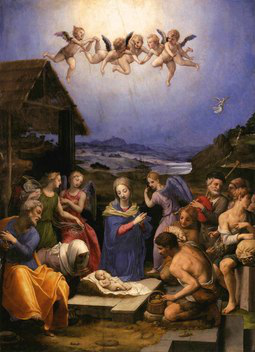

In [12]:
nativity_label="1"
nativity = list(data_dir.glob(f'{nativity_label}/*'))

PIL.Image.open(str(nativity[0]))

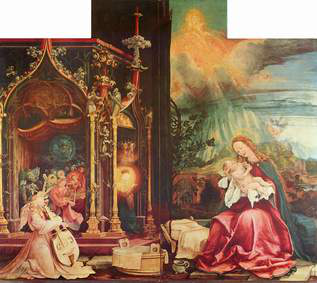

In [13]:
PIL.Image.open(str(nativity[1]))

And some random paintings:

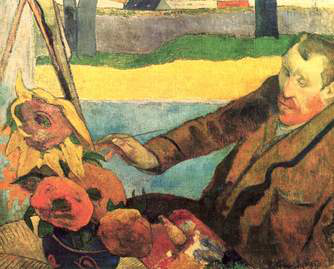

In [14]:
others_label="0"
others = list(data_dir.glob(f'{others_label}/*'))
PIL.Image.open(str(others[1]))

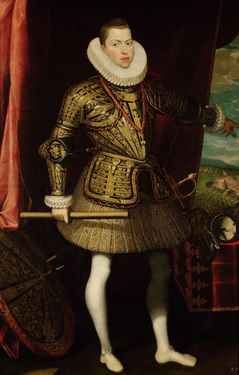

In [15]:
PIL.Image.open(str(others[2]))

# Load using keras.preprocessing

Keras provides a bunch of really convenient functions to make our life easier when working with Tensorflow. **tf.keras.preprocessing.image_dataset_from_directory** is one of them. It loads images from the files into **tf.data.DataSet** format. 



In [16]:
batch_size = 32
img_height = 300
img_width = 300


In general it is advised to split data into training data and validation data using a 80% 20% split. Remember, this is not a hard and fast rule.

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, label_mode='binary')



Found 452 files belonging to 2 classes.
Using 362 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,label_mode='binary')

Found 452 files belonging to 2 classes.
Using 90 files for validation.


In [21]:
#Retrieve a batch of images from the test set
test_data_dir = pathlib.Path("/content/resized/test_dataset")
test_batch_size=37
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=200,
  image_size=(img_height, img_width),
  batch_size=test_batch_size,label_mode='binary')

Found 37 files belonging to 2 classes.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.




In [22]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


# Visualize the data
Here are the first 9 images from the training dataset.

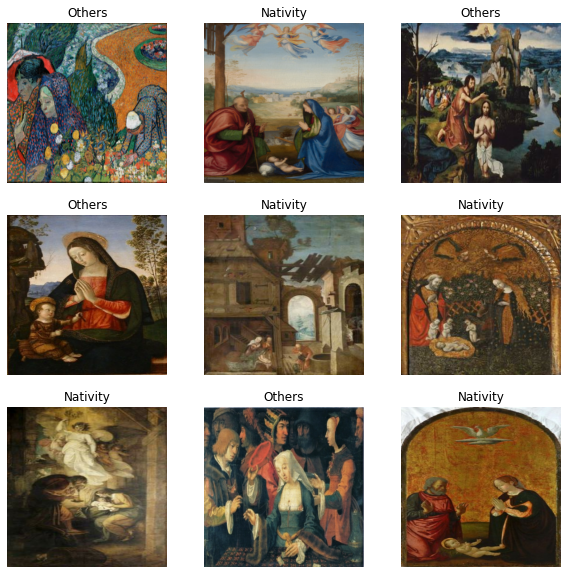

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == 1.0:
      title = "Nativity"
    else:
      title = "Others"

    plt.title(title)
    plt.axis("off")

We inspect the image_batch and labels_batch variables. 

The image_batch is a tensor of the shape (32, 300, 300, 3). This is a batch of 32 images of shape 300x300x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.



In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32, 1)


# Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


We define an utility function

In [82]:
labelMappings={"0":"Others","1":"Nativity",
               0.0:"Others",1.0 :"Nativity"}

def predictWithTestDataset(model):
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()
  print(f"After sigmoid:{predictions}")
  predictions = tf.where(predictions < 0.5, 0, 1)

  #print('Predictions:\n', predictions.numpy())
  #print('Labels:\n', label_batch)
  correctPredictions=0
  plt.figure(figsize=(20, 20))
  print(f"number predictions={len(predictions)}")
  for i in range(len(predictions)):
    ax = plt.subplot(8, 5, i +1)
    plt.imshow(image_batch[i].astype("uint8"))
    prediction = class_names[predictions[i]]
    predictionLabel = labelMappings[prediction]
    gtLabel = labelMappings[label_batch[i][0]]
    if gtLabel == predictionLabel:
      correctPredictions += 1
    plt.title(f"P={predictionLabel} GT={gtLabel}")
    plt.axis("off")
  
  accuracy = correctPredictions/len(predictions)
  print(f"Accuracy:{accuracy}")

# Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

# Create the model
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [71]:


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


# Compile the model
For this tutorial, choose the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.




In [72]:
model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])


# Model summary

View all the layers of the network using the model's summary method:

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 37, 64)       

# Train the model

In [74]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 1s 66ms/step - loss: 1.5679 - binary_accuracy: 0.5305 - val_loss: 0.6919 - val_binary_accuracy: 0.5222
Epoch 2/10
12/12 [==============================] - 1s 51ms/step - loss: 0.6857 - binary_accuracy: 0.5486 - val_loss: 0.7298 - val_binary_accuracy: 0.5222
Epoch 3/10
12/12 [==============================] - 1s 51ms/step - loss: 0.6892 - binary_accuracy: 0.5515 - val_loss: 0.6938 - val_binary_accuracy: 0.5222
Epoch 4/10
12/12 [==============================] - 1s 51ms/step - loss: 0.6466 - binary_accuracy: 0.5934 - val_loss: 0.6820 - val_binary_accuracy: 0.5556
Epoch 5/10
12/12 [==============================] - 1s 51ms/step - loss: 0.6152 - binary_accuracy: 0.6711 - val_loss: 0.6952 - val_binary_accuracy: 0.5667
Epoch 6/10
12/12 [==============================] - 1s 52ms/step - loss: 0.5810 - binary_accuracy: 0.6912 - val_loss: 0.6400 - val_binary_accuracy: 0.6556
Epoch 7/10
12/12 [==============================] - 1s 51ms/step - los

# Visualize training results

{'loss': [1.1783559322357178, 0.6830787658691406, 0.6812670230865479, 0.6605582237243652, 0.6085272431373596, 0.5693514943122864, 0.4801577031612396, 0.5033847689628601, 0.4072248339653015, 0.3030306398868561], 'binary_accuracy': [0.5055248737335205, 0.5580110549926758, 0.591160237789154, 0.560773491859436, 0.6906077265739441, 0.7044199109077454, 0.7845304012298584, 0.7596685290336609, 0.8287292718887329, 0.8784530162811279], 'val_loss': [0.6919008493423462, 0.7297500371932983, 0.6937752366065979, 0.681964099407196, 0.695195198059082, 0.6400248408317566, 0.7613269090652466, 0.6413790583610535, 0.7060906887054443, 0.6680866479873657], 'val_binary_accuracy': [0.5222222208976746, 0.5222222208976746, 0.5222222208976746, 0.5555555820465088, 0.5666666626930237, 0.6555555462837219, 0.5888888835906982, 0.6333333253860474, 0.6222222447395325, 0.6777777671813965]}


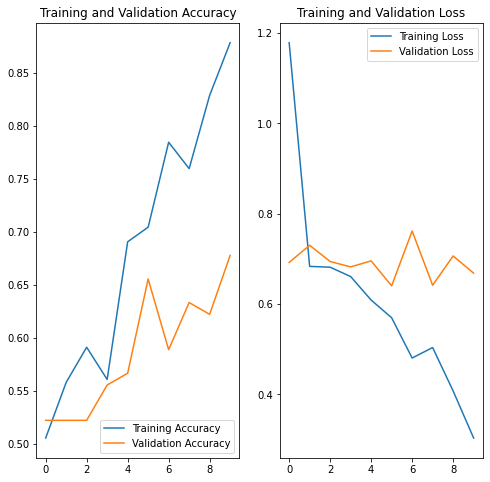

In [75]:
print(history.history)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Looking at the plots, we are seeing a typical sign of **overfitting**. **Overfitting** happens when the model fits a bit too much with the training data but does poorly against the validation data. Notice that the accuracy increases along with the epochs for the training accuracy but with the validation data, the accuracy doesn't increase and in this case the loss increasses.

[0.9816622  0.91066945 0.17033207 0.15276879 0.64471346 0.6427945
 0.8241969  0.16490935 0.49865666 0.4364782  0.5313828  0.17418459
 0.0598284  0.6873587  0.3069746  0.85159105 0.35090467 0.6789319
 0.4005225  0.11707857 0.12281718 0.5067677  0.22079542 0.90368795
 0.08495449 0.20047794 0.7590811  0.01729112 0.9429407  0.6982454
 0.0963205  0.26340413 0.6682754  0.09021647 0.08129188 0.24699785
 0.23451518]
After sigmoid:[0.7274379  0.71313715 0.54248035 0.5381181  0.65581816 0.6553849
 0.69512653 0.5411342  0.6221436  0.60741955 0.62980556 0.5434364
 0.5149526  0.6653791  0.5761466  0.7009008  0.58683693 0.66350025
 0.5988132  0.5292362  0.53066576 0.6240485  0.5549757  0.71170676
 0.52122587 0.54995227 0.6811542  0.5043227  0.71969324 0.66779864
 0.52406156 0.5654729  0.6611169  0.52253884 0.5203118  0.5614375
 0.5583616 ]
number predictions=37
Accuracy:0.43243243243243246


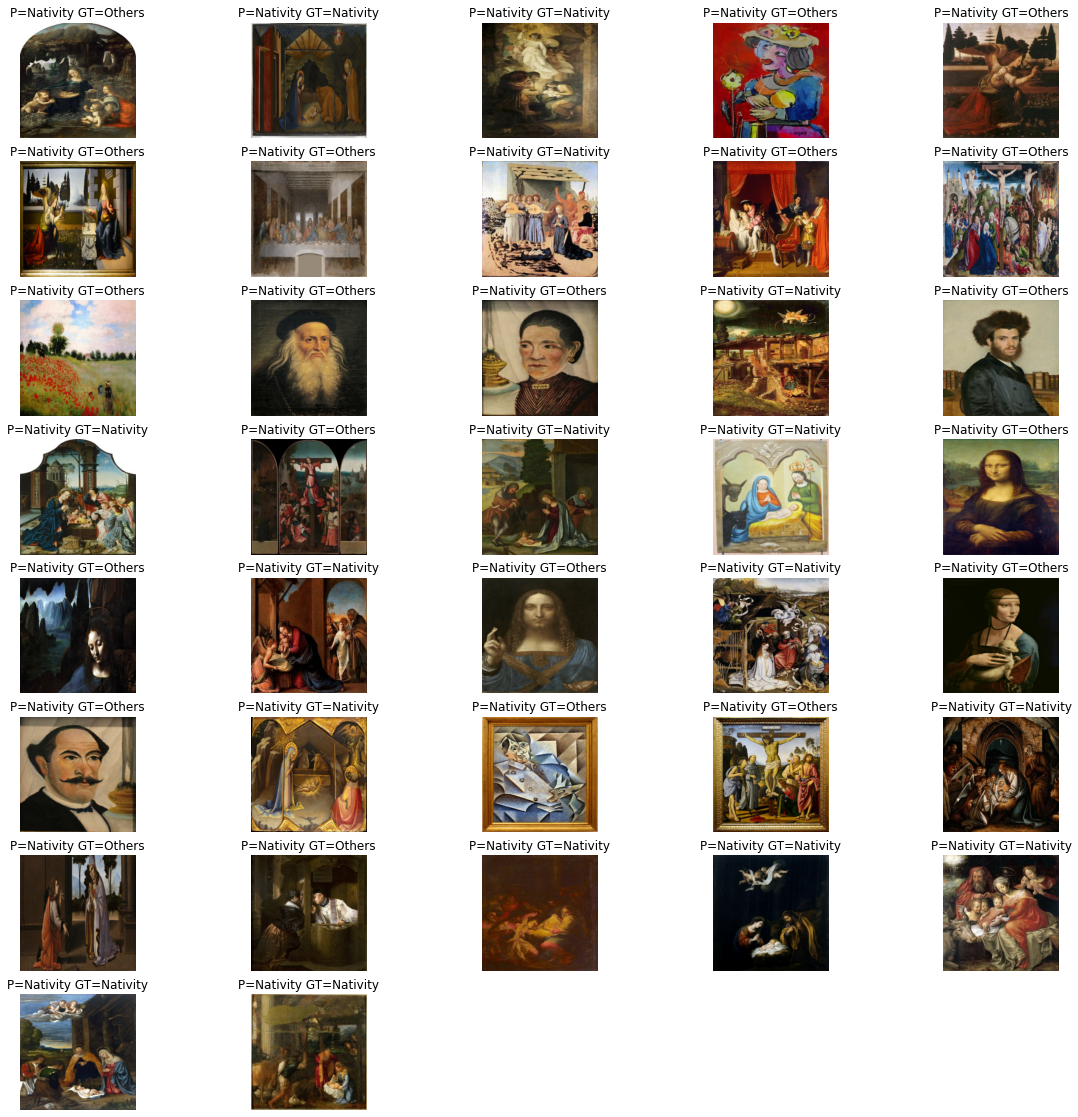

In [76]:
predictWithTestDataset(model)

# Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.



# Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1) ,
   #layers.experimental.preprocessing.RandomZoom(0.1)
   
    ]


)


Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:



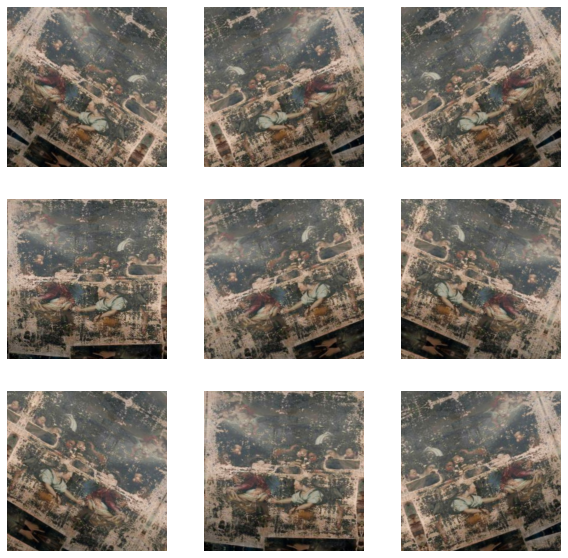

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

# Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [37]:

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


# Compile and train the model

In [38]:
from tensorflow import optimizers
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=[keras.metrics.BinaryAccuracy()])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)       

In [40]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
12/12 [==============================] - 2s 75ms/step - loss: 0.7898 - binary_accuracy: 0.4971 - val_loss: 0.6995 - val_binary_accuracy: 0.5222
Epoch 2/25
12/12 [==============================] - 1s 64ms/step - loss: 0.6865 - binary_accuracy: 0.5598 - val_loss: 0.7323 - val_binary_accuracy: 0.5222
Epoch 3/25
12/12 [==============================] - 1s 61ms/step - loss: 0.6642 - binary_accuracy: 0.5532 - val_loss: 0.6830 - val_binary_accuracy: 0.5889
Epoch 4/25
12/12 [==============================] - 1s 61ms/step - loss: 0.6647 - binary_accuracy: 0.6042 - val_loss: 0.6816 - val_binary_accuracy: 0.6000
Epoch 5/25
12/12 [==============================] - 1s 61ms/step - loss: 0.6477 - binary_accuracy: 0.6427 - val_loss: 0.6979 - val_binary_accuracy: 0.5444
Epoch 6/25
12/12 [==============================] - 1s 61ms/step - loss: 0.6307 - binary_accuracy: 0.6253 - val_loss: 0.6866 - val_binary_accuracy: 0.5333
Epoch 7/25
12/12 [==============================] - 1s 61ms/step - los

# Visualize training results
After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

{'loss': [0.7518293857574463, 0.6847917437553406, 0.6667778491973877, 0.6577527523040771, 0.6382638812065125, 0.6270540356636047, 0.6394320130348206, 0.6161797642707825, 0.614696204662323, 0.5848422646522522, 0.6003613471984863, 0.5938694477081299, 0.5721514225006104, 0.5749778747558594, 0.5527300238609314, 0.5977985858917236, 0.5766965746879578, 0.5750587582588196, 0.5627806782722473, 0.5410608053207397, 0.550212025642395, 0.5612600445747375, 0.5639939308166504, 0.5435410141944885, 0.5245653986930847], 'binary_accuracy': [0.4861878454685211, 0.5718231797218323, 0.5580110549926758, 0.610497236251831, 0.6325966715812683, 0.6464088559150696, 0.6519337296485901, 0.6657458543777466, 0.6657458543777466, 0.6740331649780273, 0.6878452897071838, 0.6767956018447876, 0.6685082912445068, 0.6767956018447876, 0.7209944725036621, 0.6685082912445068, 0.7044199109077454, 0.6823204159736633, 0.6988950371742249, 0.7044199109077454, 0.6961326003074646, 0.7099447250366211, 0.7044199109077454, 0.6933701634

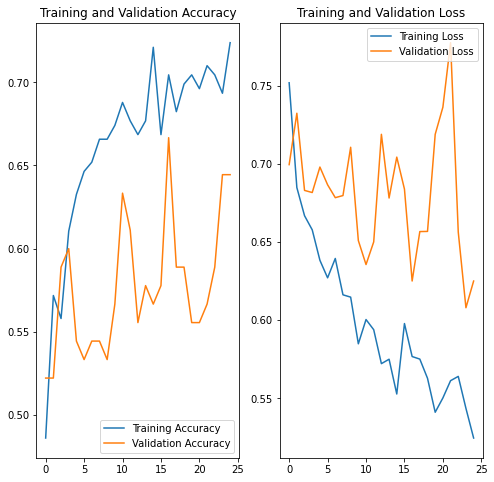

In [41]:
print(history.history)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.



number predictions=37
Accuracy:0.5135135135135135


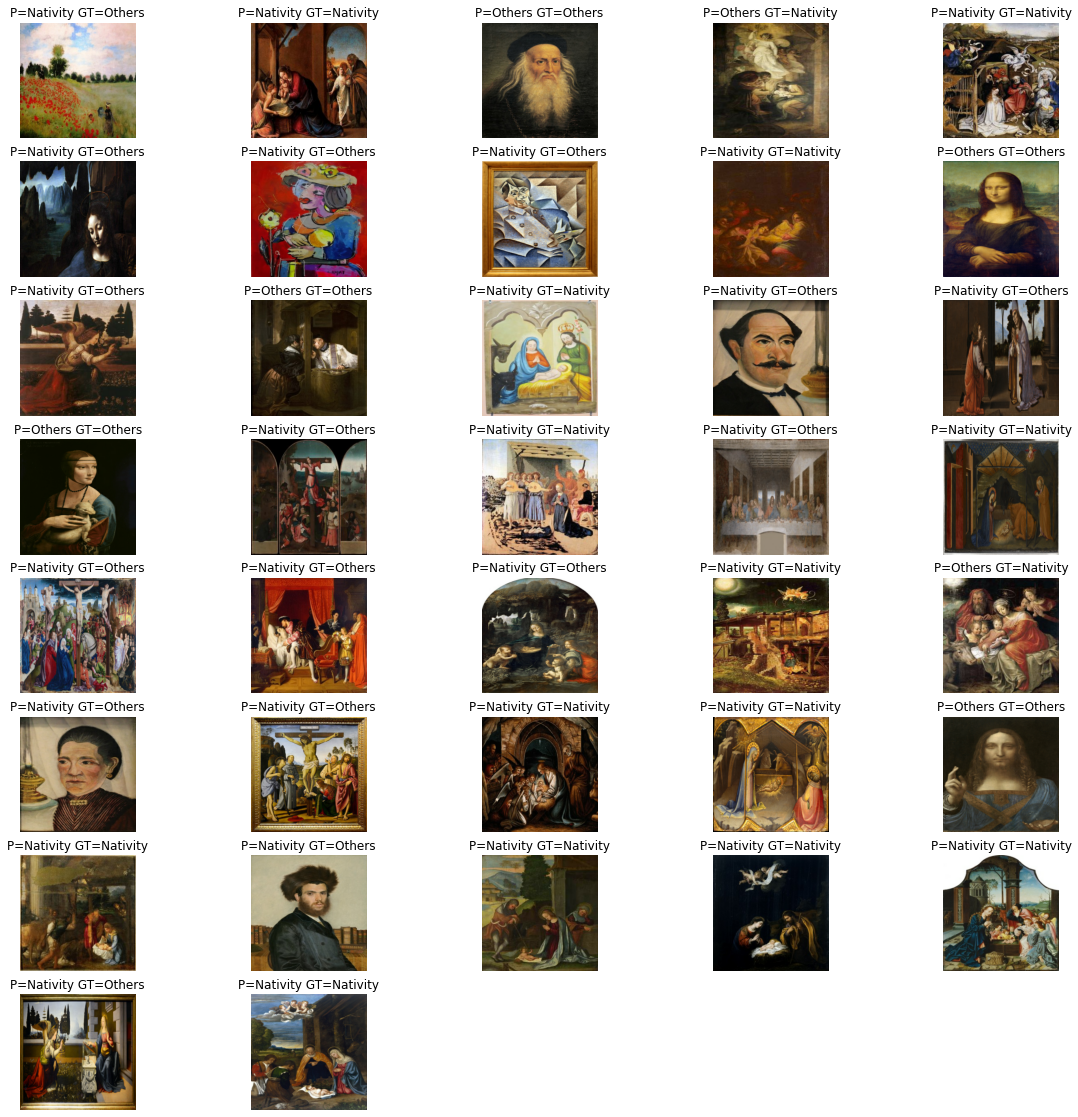

In [42]:
predictWithTestDataset(model)

# Transfer Learning

We have already used image augmentation to try and get better results from our model, and I have to say the results were not bad at all. We were able to get a model with 65% accuracy. Surely, we can do better than that, if we are able to collect hundreds more, perhaps thousands more images for our training and validation data set.

You can certainly do that, but there is another way that doesn't involve the tedious and expensive process of collecting more training data: **Transfer Learning**.

With transfer learning we can borrow a model that is already trained against thousands of images and re-train it for our use case, but with much fewer images than it would have been possible to if we trained a model from scratch.

To do so we can use Keras to download a pre-trained model with the Xception architecture already trained on Imagenet. 

To perform transfer learning we need to freeze the weights of the base model and perform the training as we normally would. You will notice that we still do the image augmentation, and the regularization.  


In [78]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049

In [79]:
# model.compile(optimizer=keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
12/12 [==============================] - 7s 384ms/step - loss: 0.6766 - binary_accuracy: 0.5570 - val_loss: 0.6784 - val_binary_accuracy: 0.5778
Epoch 2/25
12/12 [==============================] - 4s 330ms/step - loss: 0.6286 - binary_accuracy: 0.6492 - val_loss: 0.6051 - val_binary_accuracy: 0.7111
Epoch 3/25
12/12 [==============================] - 4s 333ms/step - loss: 0.5640 - binary_accuracy: 0.7234 - val_loss: 0.5647 - val_binary_accuracy: 0.7444
Epoch 4/25
12/12 [==============================] - 4s 338ms/step - loss: 0.4959 - binary_accuracy: 0.8216 - val_loss: 0.5288 - val_binary_accuracy: 0.7778
Epoch 5/25
12/12 [==============================] - 4s 335ms/step - loss: 0.4710 - binary_accuracy: 0.8396 - val_loss: 0.5054 - val_binary_accuracy: 0.8000
Epoch 6/25
12/12 [==============================] - 4s 333ms/step - loss: 0.4332 - binary_accuracy: 0.8751 - val_loss: 0.4940 - val_binary_accuracy: 0.8000
Epoch 7/25
12/12 [==============================] - 4s 326ms/ste

{'loss': [0.6637847423553467, 0.6064080595970154, 0.5371060371398926, 0.5013732314109802, 0.4691295325756073, 0.440790593624115, 0.4241580069065094, 0.40425804257392883, 0.37871575355529785, 0.3780069053173065, 0.3634445369243622, 0.3596041798591614, 0.35100531578063965, 0.3403576910495758, 0.30824851989746094, 0.33070793747901917, 0.2993714213371277, 0.3026455342769623, 0.28440582752227783, 0.295177161693573, 0.29039064049720764, 0.2722778618335724, 0.2703820466995239, 0.2565721571445465, 0.25409653782844543], 'binary_accuracy': [0.5745856165885925, 0.6878452897071838, 0.7707182168960571, 0.8038673996925354, 0.8314917087554932, 0.8508287072181702, 0.8314917087554932, 0.8425414562225342, 0.8701657652854919, 0.8701657652854919, 0.8563535809516907, 0.8563535809516907, 0.9033148884773254, 0.8701657652854919, 0.9143646359443665, 0.889502763748169, 0.9060773253440857, 0.908839762210846, 0.9254143834114075, 0.90055251121521, 0.9254143834114075, 0.908839762210846, 0.919889509677887, 0.9254143

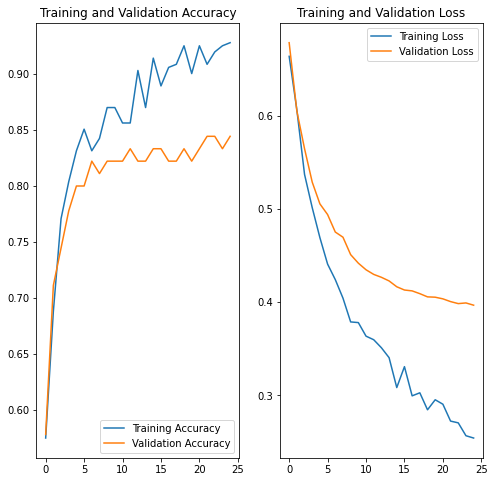

In [80]:
print(history.history)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test model against test dataset

After sigmoid:[0.6414971  0.7853975  0.6055286  0.8211809  0.8452773  0.00613335
 0.3304303  0.66226465 0.08662328 0.09323751 0.8720556  0.9517652
 0.86692524 0.8789368  0.37131113 0.7988177  0.9516907  0.38881192
 0.93873876 0.87973154 0.30758765 0.6374085  0.63871384 0.02349198
 0.0067749  0.176546   0.009826   0.01608479 0.23247328 0.8832798
 0.84608555 0.92289805 0.69591284 0.8798934  0.93106645 0.1088727
 0.01574459]
number predictions=37
Accuracy:0.7837837837837838


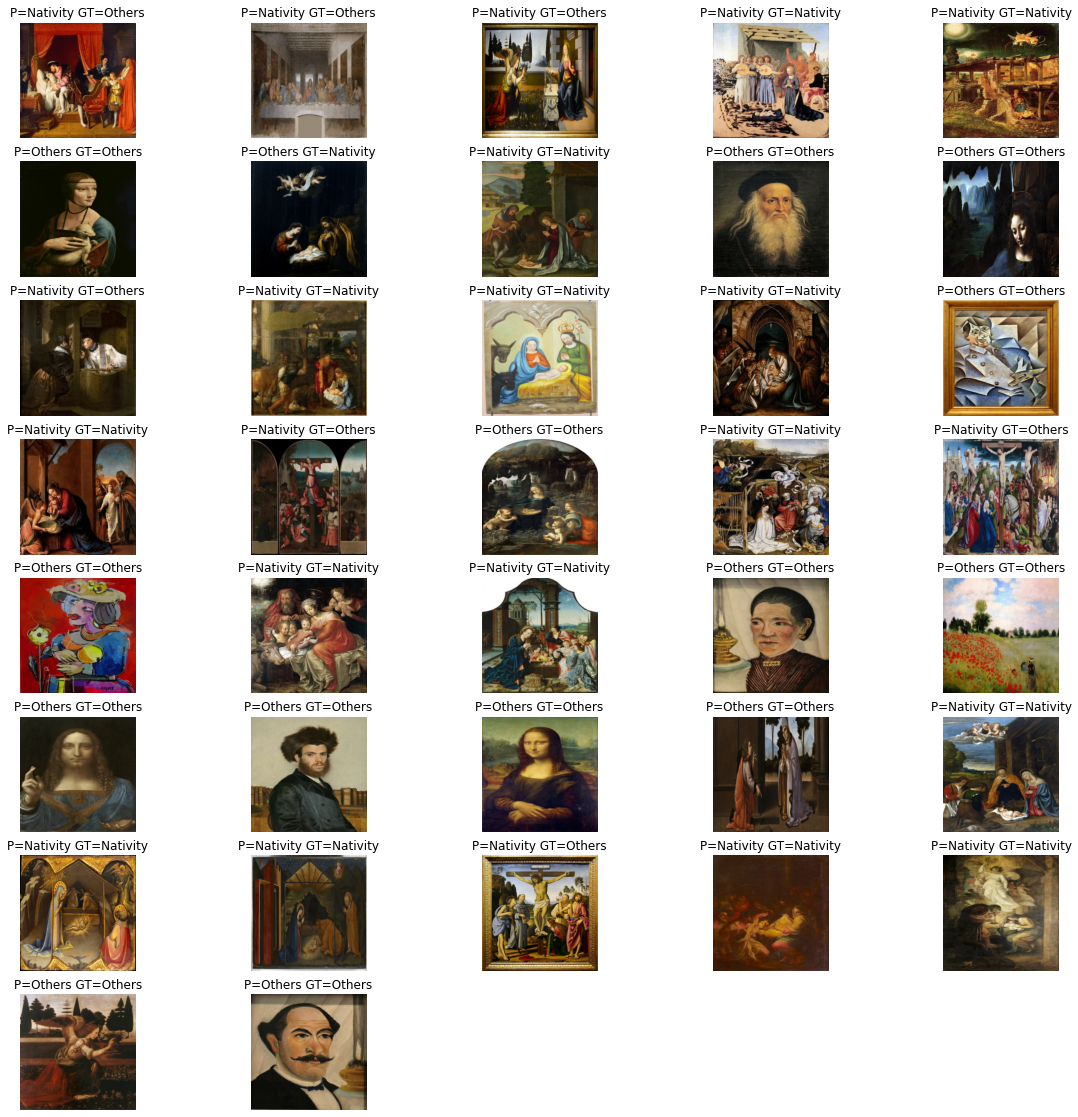

In [84]:
predictWithTestDataset(model)

In [85]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049

{'loss': [0.2340960055589676, 0.18888115882873535], 'binary_accuracy': [0.939226508140564, 0.9475138187408447], 'val_loss': [0.3530152142047882, 0.38754722476005554], 'val_binary_accuracy': [0.855555534362793, 0.8666666746139526]}


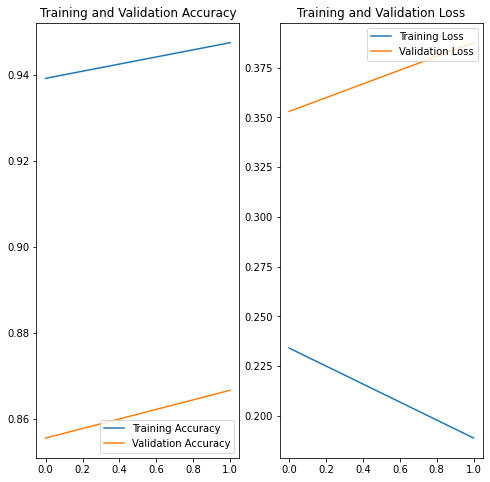

In [87]:
print(history.history)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After sigmoid:[8.7951589e-01 5.1571184e-04 9.2654288e-01 1.7610466e-01 9.7407293e-01
 1.1038618e-03 3.1603864e-04 5.2189034e-01 9.6688455e-01 7.8521949e-01
 6.1758959e-01 2.0786759e-02 2.4179441e-01 2.2810230e-03 2.8174260e-01
 9.8688531e-01 5.4286462e-01 9.9258399e-01 7.3775440e-01 4.0661697e-03
 9.7516483e-01 3.6469471e-02 2.2091758e-03 5.1744953e-02 8.4264189e-01
 3.0638683e-01 6.3300353e-01 8.3911335e-01 3.3717494e-02 6.4012372e-01
 1.5515858e-01 8.4986502e-01 9.0996867e-01 2.9448605e-01 8.1373370e-01
 2.6058277e-02 9.0475649e-01]
number predictions=37
Accuracy:0.7837837837837838


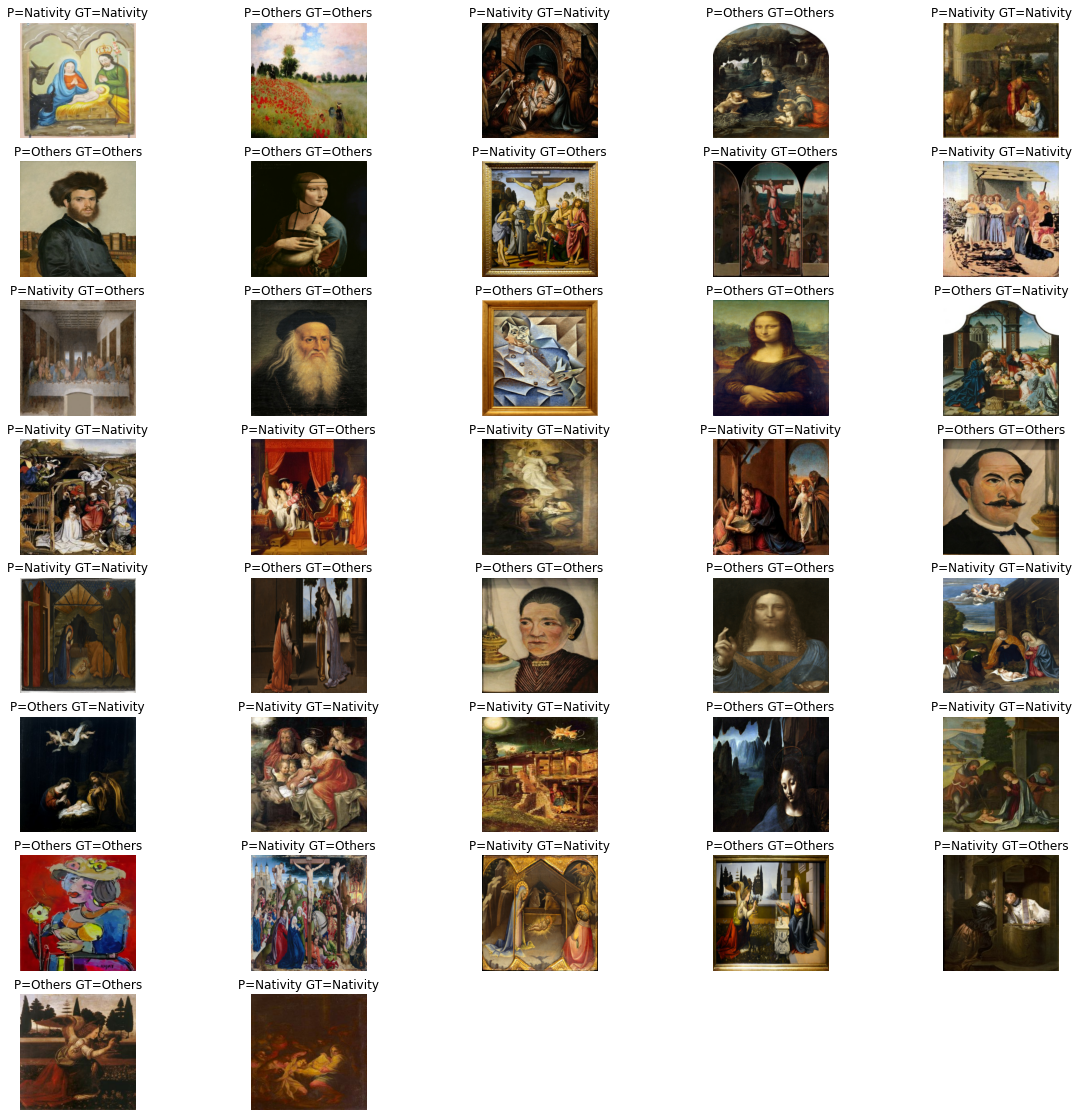

In [88]:
predictWithTestDataset(model)

The Virgin of the rocks

In [105]:
nativity_url = "https://upload.wikimedia.org/wikipedia/commons/e/e4/Leonardo_Da_Vinci_-_Vergine_delle_Rocce_%28Louvre%29.jpg"
nativity_path = tf.keras.utils.get_file('NativityPaiting', origin=nativity_url)

img = keras.preprocessing.image.load_img(
    nativity_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
predictedLabel = labelMappings[str(predictions[0].numpy()[0])]
print(predictedLabel)



[[0.1996727]]
Others


I am a little bit disappointed. Our Virgin of the Rocks painting is not recognised as a nativity painting. But is it really?

# Conclusion

We started with training a model from scratch using a simple architecture.

We have been able to get some pretty good results with a limited dataset. This is indeed very promising! There are many ways to further improve these results, from gathering more images, experimenting with different image sizes and even trying new model architectures.

Hope you found this notebook useful. And hope to see you for the next one. Happy coding!